# <center>购买商品预测</center>
===========================================================================================================================================
<p align="right">王鑫轶 大数据2001</p>
<p align="right">任新宇 大数据2001</p>

# 一、数据概览


## 1.1 导入相关库

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,LeaveOneOut
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings # 该库可以忽略警告
warnings.filterwarnings('ignore')

## 1.2 导入数据

### 1.2.1 查看训练集和测试集数据

训练集数据

In [2]:
path='data/' # 文件的路径
test_data=pd.read_csv(path+'test.csv') # 读取测试机
train_data=pd.read_csv(path+'train.csv')# 读取训练集
train_data.head()# 查看训练集数据的前五条

,salary,age,elevel,car,zipcode,credit,brand
0,119806.54480,45,0,14,4,442037.71130,0
1,78020.75094,23,0,15,2,48795.32279,0
2,50873.61880,20,3,14,4,352951.49770,0
3,72298.80402,29,4,17,0,276298.69520,0
4,128999.93560,52,1,6,0,152232.50980,0


|列名|salary|age|elevel|car|zipcode|credit|brand|
|----|------|---|------|---|-------|-----|-----|
|意义|工资|年龄|获得的最高的教育等级|车的种类|邮政编码|信用额度|品牌的电脑|

brand 是我们需要预测的标签

测试集数据

### 1.2.2 观察数据个数

In [4]:
print("the number of train set is: ", train_data.shape[0])
print("the number of test set is: ", test_data.shape[0])

the number of train set is:  9398
the number of test set is:  4500


我们可以看到训练集数据总共有9398个，测试集数据有4500个。

训练集比较大，因此可以用训练集做交叉验证，再用测试集进行验证模型是否过拟合或欠拟合。

### 1.2.3 样本描述性统计

In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


结论：

1.样本和测试变量的描述性统计量区别不大，不过两组数据的75%的分位数和最大值之间相差很大。所以样本中可能存在异常值。

2.船票价格平均值比中位数大很多，特征分布严重右偏，少量乘客船票高达521，可能是异常值。
    
3.很少的乘客年纪在64-80之间。
    
4.大概38%的样本生存率。
    
5.大多数乘客（76%）没有与父母孩子一起登船，大约30%的乘客有亲属或配偶一起登船。

# 二、数据可视化与预处理

## 2.1 缺失值查看

In [ ]:
train_data.info() # 查看信息
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


由上面可以看出 Age、Cabin、Embarked 列有的缺失值，且Cabin 列的缺失值过多，因此将 Cabin 列进行删除操做。

之后对 int 类型的 Age 列的缺失值以其平均值填充，对 object 类型的 Embarked 列的缺失值以其众数填充。

In [ ]:
train_data['Age']=train_data['Age'].fillna(np.mean(train_data['Age']))

In [ ]:
train_data['Embarked']=train_data['Embarked'].fillna(train_data.Embarked.mode()) # 对 Embarked 列进行平均值填充

## 2.2.数据分类

按照原始的数据，我们可以将变特征变量分为以下五类：

分类变量：Sex, Embarked, pclass
 
连续变量：Age, Fare

离散变量：SibSp, Parch

其他变量：Name, PassengerId, Cabin,Ticket

我们对每一个特征变量进行存活率数据查看、绘制存活率图像、由图像得出结论并进行处理工作。

### 2.2.1 分类变量

 #### Sex

a.查看不同性别的存活率

In [ ]:
train_data[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived', ascending=False) 


,Sex,Survived
0,female,0.742038
1,male,0.188908


b.作出性别与存活率的图像

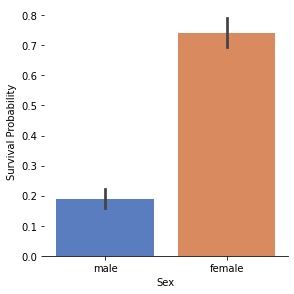

In [ ]:
g = sns.factorplot(x="Sex", y="Survived",  data=train_data,
                   size=4, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

c.结论：从图上可以明显看出，女性的存活率远高于男性

d.处理：离散化处理，male为1，female为0

In [ ]:
def sexfun(s):
    if s=='male':
        return 1
    else:
        return 0

train_data.Sex = train_data.Sex.apply(sexfun)

#### Pclass

a.查看不同舱位等级的存活率

In [ ]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


b.绘制不同舱位存活率的图像

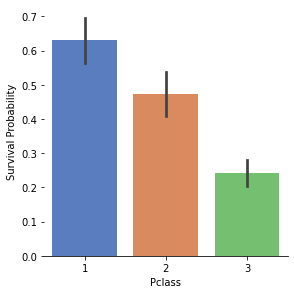

In [ ]:
g = sns.factorplot(x="Pclass", y="Survived",  data=train_data,
                   size=4, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

c.结论：舱位等级越高，存活率越高

#### Embarked

a.查看不同地点处登船的存活率

In [ ]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


b.绘制出不同地点登船的存活率图像

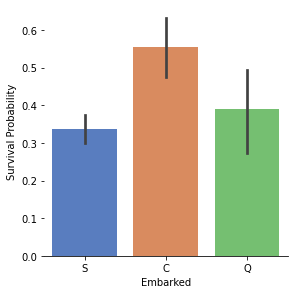

In [ ]:
g = sns.factorplot(x="Embarked", y="Survived",  data=train_data,
                   size=4, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

c.结论：从C处登船存活率最高，S和Q两处存活率相差不大

d.处理：离散化处理，将 S 转换为 0，C 转换为 1，Q 转换为 2。

In [ ]:
def EmbarkedFun(s):# 上船地点转换函数
    if s=='S':
        return 0
    elif s=='C':
        return 1
    else:
        return 2

train_data.Embarked=train_data.Embarked.apply(EmbarkedFun) # 将 S 转换为 0，C 转换为 1，Q 转换为 2。

### 2.2.2 连续变量

#### Age

a.查看不同年龄的存活率

In [ ]:
train_data['Ageband'] = pd.cut(train_data['Age'], 5)
train_data[['Ageband', 'Survived']].groupby(['Ageband'], as_index=False).mean().sort_values(by='Ageband', ascending=True)

,Ageband,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


b.绘制出不同年龄的存活率图像

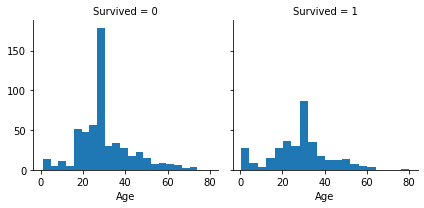

In [ ]:
g=sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

c.结论：小孩和老人的存活率较高，未存活人的平均年龄小于存活人的平均年龄

d.处理:归一化处理

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
train_data[['Age']]=min_max_scaler.fit_transform(train_data[['Age']]) # 对 Age 列进行归一化处理

####  Fare

a.查看不同票价的存活率情况

In [ ]:
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
train_data[['FareBand', 'Survived']].groupby(['FareBand'],as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


b.绘制出不同票价的存活率图像

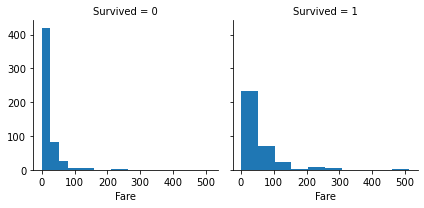

In [ ]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Fare', bins=10)

c.结论：票价越高，存活率越高

d.处理：归一化处理

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
train_data[['Fare']]=min_max_scaler.fit_transform(train_data[['Fare']]) # 对 Fare 和 Age 列进行归一化处理
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ageband,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",1,0.271174,1,0,A/5 21171,0.014151,NaN,0,"(16.336, 32.252]","(-0.001, 7.91]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.472229,1,0,PC 17599,0.139136,C85,1,"(32.252, 48.168]","(31.0, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",0,0.321438,0,0,STON/O2. 3101282,0.015469,NaN,0,"(16.336, 32.252]","(7.91, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.434531,1,0,113803,0.103644,C123,0,"(32.252, 48.168]","(31.0, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",1,0.434531,0,0,373450,0.015713,NaN,0,"(32.252, 48.168]","(7.91, 14.454]"


### 2.2.3 离散变量

#### Sibsp

a.查看不同兄弟姐妹人数在船上的存活率

In [ ]:
train_data[["SibSp", "Survived"]].groupby(['SibSp'],as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


b.绘制不同兄弟姐妹在船上人数的存活率图像

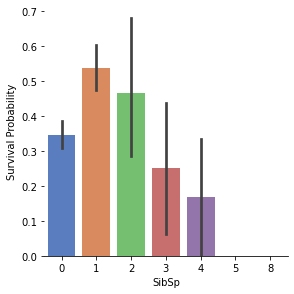

In [ ]:
g = sns.factorplot(x="SibSp", y="Survived",  data=train_data,
                   size=4, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

c.结论：船上兄弟姐妹或配偶人数越多，存活率越低

#### Parch

a.查看乘客父母孩子在船上的不同人数的存活率

In [ ]:
train_data[["Parch", "Survived"]].groupby(['Parch'],\
as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


b.绘制出乘客父母孩子在船上的人数的存活率图像

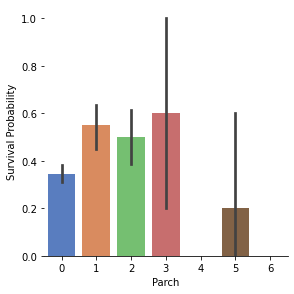

In [ ]:
g = sns.factorplot(x="Parch", y="Survived",  data=train_data,
                   size=4, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

c.结论：父母孩子个数为3人的存活率最高

同时我门认为这两列数据有较高的相关性，所以将他们合并。

In [ ]:
train_data['Family'] = train_data.SibSp+train_data.Parch

### 2.2.4 其他变量

#### Name

我们认为乘客的姓名对是否存活无影响，所以将改列的数据删除。

In [ ]:
train_data.drop(labels=['Name'],inplace=True,axis=1)

#### Passengered

 PassengerId 列对分析并没有实际意义，所以删除该列

In [ ]:
train_data.drop(labels=['PassengerId'],inplace=True,axis=1)

#### Cabin

从上面缺失值查看中可以看出，Cabin 列的缺失值过多，因此将 Cabin 列进行删除操做。

In [ ]:
train_data.drop(labels='Cabin',inplace=True,axis=1)

#### Ticket

Ticket 十分杂乱，我们选择剔除

In [ ]:
train_data.drop(labels=['Ticket'],inplace=True,axis=1)

删除多余的数据列

In [ ]:
train_data.drop(labels=['SibSp','Parch','Ageband','FareBand'],inplace=True,axis=1)

# 三、模型训练

## 3.1 交叉验证

此数据集的样本并不大，所以直接将数据集拆分为两个互斥的集合，其中一个作为训练集，一个作为测试集并不合适。它会损失一部分信息。

所以我们这里使用：**交叉验证(留一法交叉验证)**

它把每一个数据点都当成一个测试集，所以，数据集中有多少个样本，它就要迭代多少次。

如果数据集的数据量较大的话，是比较耗时的；但是，如果数据量很小的话，它的评分准确度是最高的。

In [ ]:
cv=LeaveOneOut() # 创建 留一法交叉验证 对象

### 3.1.1 逻辑回归模型

逻辑回归与线性回归都是一种广义线性模型（generalized linear model，GLM）。

具体的说，都是从指数分布族导出的线性模型，线性回归假设Y|X服从高斯分布，逻辑回归假设Y|X服从伯努利分布。

In [ ]:
logreg=LogisticRegression(max_iter=2000)
scores = cross_val_score(logreg,train_data.iloc[:,1:], train_data['Survived'],cv=cv) # 使用交叉训练 训练逻辑回归模型
print("平均分:{:.4f}".format(scores.mean()))

平均分:0.7969


**调参**

我们考察LogisticRegression()的参数C对分类模型的预测性能的影响。C是正则化项系数的倒数，它越小则正则化项的权重越大。


In [ ]:
Cs=np.logspace(-2,4,num=10)
scores=[]
for C in Cs:
    regr=LogisticRegression(C=C)
    scores.append(cross_val_score(regr,train_data.iloc[:,1:], train_data['Survived'],cv=cv).mean())


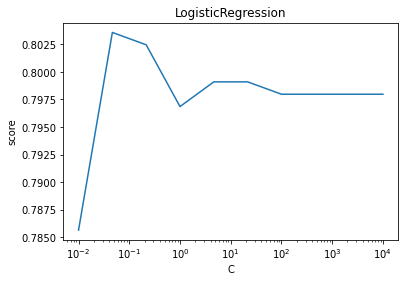

In [ ]:
# 画出准确率关于C的变化趋势图
fig=plt.figure
plt.xlabel(r'C')
plt.ylabel(r'score')
plt.xscale('log')
plt.title('LogisticRegression')
plt.plot(Cs,scores)
plt.show()

### 3.1.2 K-近邻算法

knn算法的**基本法则**是：相同类别的样本之间在特征空间中应当聚集在一起。 

In [ ]:
knn=KNeighborsClassifier()
scores = cross_val_score(knn,train_data.iloc[:,1:], train_data['Survived'],cv=cv) # 使用交叉训练 knn模型
print("平均分:{:.4f}".format(scores.mean()))

平均分:0.7980


**调参**

KNN算法我们主要要考虑三个重要的要素，对于固定的训练集，只要这三点确定了，算法的预测方式也就决定了。

这三个最终的要素是**k值的选取**，**距离度量的方式**和**分类决策规则**。

对于分类决策规则，一般都是使用前面提到的多数表决法。

所以我们重点是关注与**k值的选择**和**距离的度量方式**。

当 p=1 时，表示距离的计算方式是 *曼哈顿距离* 

当 p=2 时，表示的是 *欧几里得距离* 

In [ ]:
Ps=[1,2]# 表示不同的距离计算方法
k_scores = {}# 将不同德参数的分数以字典储存
k_range = range(1,31)
for p in Ps:
    for k in k_range:
        knn = KNeighborsClassifier(n_jobs=2, n_neighbors=k,p=p)
        sco = cross_val_score(knn, train_data.iloc[:,1:], train_data['Survived'],cv=cv,scoring='accuracy')
        k_scores[sco.mean()]=[p,k]
f=k_scores[max(k_scores.keys())]
str='当： p={} n_neighbors={} 时\n平均准确率最高，为{}'.format(f[0],f[1],max(k_scores.keys()))
print(str)

当： p=1 n_neighbors=22 时
平均准确率最高，为0.813692480359147


所以最后我们打算用KNN模型来进行预测

## 3.2 模型预测

### 测试数据的预处理

In [ ]:
test_data['Family'] = test_data.SibSp+test_data.Parch
test_data.drop(labels=['Name','Ticket','PassengerId','SibSp','Parch','Cabin'],inplace=True,axis=1)
# 删除 'Name','Ticket','PassengerId','SibSp','Parch','Cabin' 列
test_data['Age']=test_data['Age'].fillna(np.mean(test_data['Age']))
test_data['Embarked']=test_data['Embarked'].fillna(test_data.Embarked.mode()) # 对 Age 和 Embarked 列进行平均值填充
test_data.Sex = test_data.Sex.apply(sexfun) # 男性为 1，女性为 0。
test_data.Embarked=test_data.Embarked.apply(EmbarkedFun) # 将 S 转换为 0，C 转换为 1，Q 转换为 2。
test_data['Fare']=test_data['Fare'].fillna(np.mean(test_data['Fare']))

### 模型训练和预测

In [ ]:
knn=KNeighborsClassifier(p=1,n_neighbors=22)
knn.fit(train_data.iloc[:,1:],train_data['Survived'])
test_data['Survived']=knn.predict(test_data)


#### 输出 csv 文件

In [ ]:
ans=pd.DataFrame({'PassengerId':range(892,1310),'Survived':test_data['Survived'].values})
ans.to_csv("predicted2.csv",index=False)

# 四、总结

   在参与本次作业的过程中，参考学习了很多分析思路以及数据处理技巧，前面的数据预处理工作非常重要，对每一项数据进行分析，可视化，之后再思考合适的处理方式，缺失值的填充方法以及异常值都会直接影响模型预测的准确性。后期模型预测主要用了逻辑回归模型和K近邻模型，通过模型训练与比较，从而尽可能得出更高的预测率。同时，我们也认真思考了排版方式，考虑如何让我们的思路清晰地呈现。此次作业也让我们更多地接触了此类竞赛，通过一遍遍的修改，让我们受益匪浅。

# 结果

![图片](ans.png "答案")


# 参考资料
> [（十）K近邻法（KNN）](https://codetd.com/article/2770881)
> 
> [Python机器学习之交叉验证](https://www.jianshu.com/p/e738226c54f0)
>
> [机器学习实战——kaggle 泰坦尼克号生存预测——六种算法模型实现与比较](https://blog.csdn.net/yangshaojun1992/article/details/106314927/)
>
> [一起学数据分析 kaggle 泰坦尼克任务 2](https://www.bilibili.com/video/BV14X4y1A7fa/)